<a href="https://colab.research.google.com/github/UOS-COMP6252/public/blob/main/lecture8/transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="text-align: center;">COMP6252 Deep Learning Technologies</h1>
<h2 style="text-align: center;"> Transfer Learning</h2>

## Download data

In [1]:
import sys,os
from pathlib import Path
IN_COLAB = 'google.colab' in sys.modules
# if IN_COLAB:
  # from google.colab import files
  # file=files.upload()
  # %mkdir /root/.kaggle
  # %mv kaggle.json  /root/.kaggle

if not os.path.exists("flowers-recognition.zip"):
   !kaggle datasets download -d alxmamaev/flowers-recognition

if not os.path.isdir("flowers"):
   !unzip flowers-recognition.zip >/dev/null



Dataset URL: https://www.kaggle.com/datasets/alxmamaev/flowers-recognition
License(s): unknown
 96% 215M/225M [00:01<00:00, 181MB/s]
100% 225M/225M [00:01<00:00, 198MB/s]


#### Usual imports

In [2]:
import getpass
import os
try:
  import comet_ml
except ModuleNotFoundError:
  %pip install comet_ml
  import comet_ml
comet_api_key=os.environ.get("COMET_API_KEY")
if comet_api_key is None:
  comet_api_key=getpass.getpass("Enter key")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 720.0/720.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 979.7/979.7 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.8/144.8 kB 6.1 MB/s eta 0:00:00
  Attempting uninstall: python-box
    Found existing installation: python-box 7.3.2
    Uninstalling python-box-7.3.2:
      Successfully uninstalled python-box-7.3.2
Enter key··········


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import  transforms
from torch.utils.data import Dataset,DataLoader,random_split
import matplotlib.pyplot as plt
import copy

In [4]:
try:
        import timm
except:
        %pip install timm==0.4.12
        import timm

In [5]:
WHERE_TO_GET_MODEL='hub'# options: 'timm','torchvision','hub'
last_layer_only=False

In [6]:
seed=9797
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True


### Create custom dataset class

- Since we use ```random_split``` we cannot use different transforms to the training and validation datasets
- Dataset is an abstract class. It cannot be instantiated
- We need to wrap the datasets obtained from ```random_split``` with a custom dataset class

In [7]:
class MyDataset(Dataset):
    def __init__(self,subset,transform=None):
        self.subset=subset
        self.transform=transform
    def __getitem__(self,idx):
        x,y=self.subset[idx]
        if self.transform:
            x=self.transform(x)
        return x,y
    def __len__(self):
        return len(self.subset)

#### Data augmentation


In [8]:
augment_choices={'trivial':transforms.TrivialAugmentWide(),'random':transforms.RandAugment(),
                 'mix':transforms.AugMix(),'auto':transforms.AutoAugment()}
aug='trivial'

In [9]:
data_transforms = {
     'train':  transforms.Compose([ transforms.CenterCrop(224),transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [.5, .5, .5])
    ]) if aug=='None' else

     transforms.Compose([ transforms.TrivialAugmentWide(),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [.5, .5, .5])
    ]),

    'val': transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [.5, .5, .5])
    ])
}



- Why did we choose 224?
- Because most models are pre-trained on the ImageNet dataset
- Which uses image sizes of 224x224

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


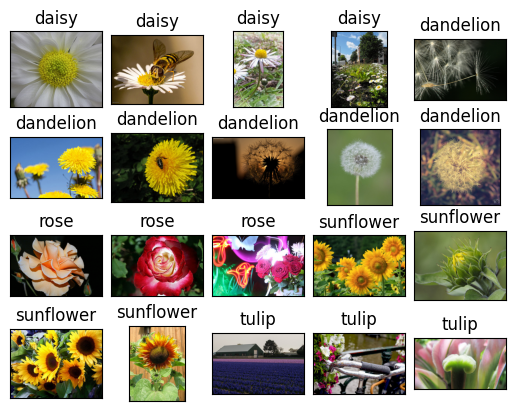

In [10]:
dataset=torchvision.datasets.ImageFolder("flowers")
class_names=dataset.classes
print(class_names)
fig=plt.figure()
fig.tight_layout()
plt.subplots_adjust( wspace=.1, hspace=.3)
for i in range(20):
            #img,label=next(itr)
            img,label=dataset[i*200]
            t=fig.add_subplot(4,5,i+1)
            # set the title of the image equal to its label
            t.set_title(class_names[label])
            t.axes.get_xaxis().set_visible(False)
            t.axes.get_yaxis().set_visible(False)
            plt.imshow(img)

In [11]:

train_d,valid_d=random_split(dataset,lengths=[0.8,0.2])

datasets={'train':train_d,'val':valid_d}
image_datasets = {x: MyDataset(datasets[x],data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True if x=='train' else False, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### What models are available?

In [12]:
list_of_models=torchvision.models.list_models()
resnets=[m for m in list_of_models if 'resnet' in m]

In [13]:
print(resnets)

['deeplabv3_resnet101', 'deeplabv3_resnet50', 'fasterrcnn_resnet50_fpn', 'fasterrcnn_resnet50_fpn_v2', 'fcn_resnet101', 'fcn_resnet50', 'fcos_resnet50_fpn', 'keypointrcnn_resnet50_fpn', 'maskrcnn_resnet50_fpn', 'maskrcnn_resnet50_fpn_v2', 'quantized_resnet18', 'quantized_resnet50', 'resnet101', 'resnet152', 'resnet18', 'resnet34', 'resnet50', 'retinanet_resnet50_fpn', 'retinanet_resnet50_fpn_v2', 'wide_resnet101_2', 'wide_resnet50_2']


In [14]:
timm_models=timm.list_models()
timm_resnets=[m for m in timm_models if 'resnet' in m]

In [15]:
print(timm_resnets)

['cspresnet50', 'cspresnet50d', 'cspresnet50w', 'eca_resnet33ts', 'ecaresnet26t', 'ecaresnet50d', 'ecaresnet50d_pruned', 'ecaresnet50t', 'ecaresnet101d', 'ecaresnet101d_pruned', 'ecaresnet200d', 'ecaresnet269d', 'ecaresnetlight', 'gcresnet33ts', 'gcresnet50t', 'inception_resnet_v2', 'lambda_resnet26rpt_256', 'lambda_resnet26t', 'lambda_resnet50ts', 'legacy_seresnet18', 'legacy_seresnet34', 'legacy_seresnet50', 'legacy_seresnet101', 'legacy_seresnet152', 'nf_ecaresnet26', 'nf_ecaresnet50', 'nf_ecaresnet101', 'nf_resnet26', 'nf_resnet50', 'nf_resnet101', 'nf_seresnet26', 'nf_seresnet50', 'nf_seresnet101', 'resnet10t', 'resnet14t', 'resnet18', 'resnet18d', 'resnet26', 'resnet26d', 'resnet26t', 'resnet32ts', 'resnet33ts', 'resnet34', 'resnet34d', 'resnet50', 'resnet50_clip', 'resnet50_clip_gap', 'resnet50_gn', 'resnet50_mlp', 'resnet50c', 'resnet50d', 'resnet50s', 'resnet50t', 'resnet50x4_clip', 'resnet50x4_clip_gap', 'resnet50x16_clip', 'resnet50x16_clip_gap', 'resnet50x64_clip', 'resnet5

In [16]:
model=timm.create_model('resnet18',pretrained=True)
print(list(model.named_modules())[-1])
model.reset_classifier(10)
print(list(model.named_modules())[-1])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

('fc', Linear(in_features=512, out_features=1000, bias=True))
('fc', Linear(in_features=512, out_features=10, bias=True))


In [17]:
model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
print(list(model.named_modules())[-1])

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 37.7MB/s]


('fc', Linear(in_features=512, out_features=1000, bias=True))


In [18]:
comet_ml.init(project_name="flower-classification")
experiment=comet_ml.Experiment(api_key=comet_api_key)

COMET WARNING: comet_ml.init() is deprecated and will be removed soon. Please use comet_ml.login()


Please paste your Comet API key from https://www.comet.com/api/my/settings/
(api key may not show as you type)
Comet API key: ··········


COMET INFO: Valid Comet API Key saved in /root/.comet.config (set COMET_CONFIG to change where it is saved).
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/peedee114/flower-classification/7bdfb40813c54b03b021e3099761b6f3



#### Evaluation function

In [19]:

def evaluate(model, criterion):
    with torch.no_grad():
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in dataloaders['val']:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes['val']
        epoch_acc = running_corrects.double() / dataset_sizes['val']
    return epoch_loss,epoch_acc

#### Training loop

In [20]:
def train_model(model, criterion, optimizer,scheduler=None, num_epochs=10):

    for epoch in range(num_epochs):
        model.train()
        running_loss,running_corrects =0.0, 0
        best_model_wts = copy.deepcopy(model.state_dict())
        best_acc = 0.0

        for inputs, labels in dataloaders['train']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        if scheduler != None:
            scheduler.step()

        epoch_loss = running_loss / dataset_sizes['train']
        epoch_acc = running_corrects.double() / dataset_sizes['train']
        v_loss,v_acc=evaluate(model,criterion)
        experiment.log_metrics({"train_loss":epoch_loss,"train_acc":epoch_acc},epoch=epoch)

        experiment.log_metrics({"val_loss":v_loss,"val_acc":v_acc},epoch=epoch)
        if  v_acc > best_acc:
                best_acc = v_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        if epoch%5==0:
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            print("t_loss={:.4f},t_acc={:.4f}".format(epoch_loss,epoch_acc))
            print("v_loss={:.4f},v_acc={:.4f}".format(v_loss,v_acc))
    ## training is done. Return the model with the best validation accuracy
    model.load_state_dict(best_model_wts)
    return model

IMPORTANT: for ```huggingface/pytorch-image-models``` one must install huggingface_hub.
Also some versions of timm are incompatible with torch hub. The culprit is usually cached models
in ```.cache/torch/hub/```

For vision timm almost surely has what you need. In case you need models for other applications or non-standard models
torch hub is more flexible. The main function is ```torch.hub.load(githubURL,model)```

In [21]:
if WHERE_TO_GET_MODEL=='timm':

    #model_name='resnet18'
    model_name='vit_base_patch16_224'
    #model_name='deit_base_patch16_224'
    model=timm.create_model(model_name=model_name,pretrained=True)
    if last_layer_only:
        for p in model.parameters():
            p.requires_grad=False  # declaring the weights to be non trainable aka freezed weights

    model.reset_classifier(len(class_names))

elif WHERE_TO_GET_MODEL=='torchvision':
    model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
    nfeatures = model.fc.in_features
    if last_layer_only:
        for p in model.parameters():
            p.requires_grad=False
    model.fc = nn.Linear(nfeatures, len(class_names)) # This layer is trainable

else:
    model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)
    #model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)
    #model = torch.hub.load('huggingface/pytorch-image-models', 'vit_base_patch16_224', pretrained=True)
    if last_layer_only:
        for p in model.parameters():
            p.requires_grad=False

    nfeatures = model.fc.in_features
    ### HuggingFace models have a standardized output interface
    ### When using Hub one needs to go case by case
    #nfeatures = model.fc.in_features
    model.fc = nn.Linear(nfeatures, len(class_names))
    #model.reset_classifier(len(class_names))



optimizer= optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/Conv

In [22]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)

In [23]:
 model= train_model(model, criterion, optimizer,scheduler=scheduler,num_epochs=10)


Epoch 0/9
----------
t_loss=0.9246,t_acc=0.6911
v_loss=0.4289,v_acc=0.8725
Epoch 5/9
----------
t_loss=0.2138,t_acc=0.9230
v_loss=0.2051,v_acc=0.9340


#### Saving  a PyTorch model
- In reality we save the weights
- Saving the model as a whole is also possible but could break easily
- Preference for the first method

In [24]:
torch.save(model.state_dict(),"last-only-weights")

- The weights can be loaded as follows
- Note that the model needs to be instantiated first

In [25]:

model.load_state_dict(torch.load("last-only-weights"))

<ipython-input-25-58707a7c9e07>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("last-only-weights"))


<All keys matched successfully>